In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import numpy as np
import pandas as pd

def load_signals(data_dir, split):
    signal_types = [
        'body_acc_x', 'body_acc_y', 'body_acc_z',
        'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
        'total_acc_x', 'total_acc_y', 'total_acc_z'
    ]
    signals = []
    for sig in signal_types:
        file_path = os.path.join(data_dir, split, 'Inertial Signals', f"{sig}_{split}.txt")
        signal = np.loadtxt(file_path)
        signals.append(signal)
    return np.dstack(signals)  # shape: (samples, timesteps, features)

def load_labels(data_dir, split):
    file_path = os.path.join(data_dir, split, f"y_{split}.txt")
    return pd.read_csv(file_path, header=None).values.flatten() - 1  # zero-indexed

def load_uci_har_dataset(data_dir):
    X_train = load_signals(data_dir, 'train')
    y_train = load_labels(data_dir, 'train')
    X_test = load_signals(data_dir, 'test')
    y_test = load_labels(data_dir, 'test')
    return X_train, y_train, X_test, y_test

DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset'
X_train, y_train, X_test, y_test = load_uci_har_dataset(DATA_DIR)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

def split_sequences(data, window_size=128, step=64):
    """
    Split the data into sequences with overlapping windows

    Args:
        data: Input data with shape (n_samples, n_features)
        window_size: Number of time steps in each sequence
        step: Step size between consecutive sequences

    Returns:
        Sequences with shape (n_sequences, window_size, n_features)
    """
    n_samples, n_features = data.shape
    sequences = []

    for i in range(0, n_samples - window_size + 1, step):
        sequence = data[i:i + window_size]
        sequences.append(sequence)

    return np.array(sequences)



# Check the current shape of the data
print(f"Original training data shape: {X_train.shape}")
print(f"Original test data shape: {X_test.shape}")

# The data already has 128 timestamps per sample, so we can use it directly
# If we need to adjust window size or create overlapping windows:
window_size = 128  # This is already the size in the dataset
step = 128  # Non-overlapping by default - set to smaller value for overlap

# Check if we need to reshape the data
if X_train.shape[1] != window_size or step != window_size:
    print("Reshaping data to adjust window size or create overlapping samples...")
    # Flatten the data to 2D and then recreate sequences
    X_train_flat = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
    X_test_flat = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])

    # Create new sequences
    X_train_seq = split_sequences(X_train_flat, window_size=window_size, step=step)
    X_test_seq = split_sequences(X_test_flat, window_size=window_size, step=step)

    # Create corresponding labels for sequences
    # For each sequence, we'll use the mode of the labels
    orig_samples_per_window = X_train.shape[1] / window_size

    y_train_seq = []
    for i in range(0, len(X_train_flat) - window_size + 1, step):
        # Map back to original sample indices
        orig_sample_idx = int(i / X_train.shape[1])
        mode_label = y_train[orig_sample_idx]
        y_train_seq.append(mode_label)

    y_test_seq = []
    for i in range(0, len(X_test_flat) - window_size + 1, step):
        # Map back to original sample indices
        orig_sample_idx = int(i / X_test.shape[1])
        mode_label = y_test[orig_sample_idx]
        y_test_seq.append(mode_label)

    y_train_seq = np.array(y_train_seq)
    y_test_seq = np.array(y_test_seq)
else:
    # If no reshaping is needed, use the data directly
    X_train_seq = X_train
    X_test_seq = X_test
    y_train_seq = y_train
    y_test_seq = y_test

# One-hot encode labels
y_train_seq_onehot = tf.keras.utils.to_categorical(y_train_seq, num_classes=6)
y_test_seq_onehot = tf.keras.utils.to_categorical(y_test_seq, num_classes=6)

print(f"Final training data shape: {X_train_seq.shape}")
print(f"Final training labels shape: {y_train_seq_onehot.shape}")
print(f"Final test data shape: {X_test_seq.shape}")
print(f"Final test labels shape: {y_test_seq_onehot.shape}")

Train shape: (7352, 128, 9) (7352,)
Test shape: (2947, 128, 9) (2947,)
Original training data shape: (7352, 128, 9)
Original test data shape: (2947, 128, 9)
Final training data shape: (7352, 128, 9)
Final training labels shape: (7352, 6)
Final test data shape: (2947, 128, 9)
Final test labels shape: (2947, 6)


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers # Import optimizers here

# -------------------------
# ABFA 모듈 정의
# -------------------------
class ABFA(tf.keras.layers.Layer):
    def __init__(self, filters, activity_classes=6, dropout_rate=0.2, **kwargs):
        super(ABFA, self).__init__(**kwargs)
        self.filters = filters
        self.activity_classes = activity_classes
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.action_prototypes = self.add_weight(
            name='action_prototypes',
            shape=(self.activity_classes, input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.embedding_proj = layers.Dense(input_shape[-1])
        self.augment_proj = layers.Dense(input_shape[-1])
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(self.dropout_rate)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)
        super().build(input_shape)

    def call(self, inputs):
        x_proj = self.embedding_proj(inputs)
        proto_similarity = tf.einsum('btd,cd->btc', x_proj, self.action_prototypes)
        proto_attention = tf.nn.softmax(proto_similarity, axis=-1)
        enhanced = tf.einsum('btc,cd->btd', proto_attention, self.action_prototypes)
        augmented = self.augment_proj(enhanced)
        x = self.bn(inputs + augmented)
        x = self.dropout(x)
        return self.layer_norm(x)

# -------------------------
# MST Block 정의
# -------------------------
class MST_Block(layers.Layer):
    def __init__(self, filters, kernel_sizes=(3, 5, 7), **kwargs):
        super(MST_Block, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_sizes = kernel_sizes

        if len(kernel_sizes) == 3:
            self.filter_dims = [filters // 4, filters // 4, filters // 2]
        else:
            self.filter_dims = [filters // 2, filters // 2]

        self.conv_layers = []
        for i, k_size in enumerate(kernel_sizes):
            self.conv_layers.append(
                layers.DepthwiseConv1D(
                    kernel_size=k_size,
                    strides=1,
                    padding='same',
                    depth_multiplier=1
                )
            )
        self.proj_layers = [
            layers.Conv1D(self.filter_dims[i], kernel_size=1, padding='same') for i in range(len(kernel_sizes))
        ]
        self.output_proj = layers.Conv1D(filters, kernel_size=1)

    def call(self, inputs):
        outputs = []
        for conv, proj in zip(self.conv_layers, self.proj_layers):
            x = conv(inputs)
            x = proj(x)
            outputs.append(x)
        x = layers.Concatenate()(outputs)
        return self.output_proj(x)

# -------------------------
# 모델 정의
# -------------------------
def build_model3(input_shape, num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # Initial projection
    x = layers.Conv1D(64, kernel_size=1, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(128, kernel_size=1, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Multi-Scale CNN Path
    kernel_sizes = [3, 7, 11]
    multi_scale_outputs = []
    for k in kernel_sizes:
        branch = layers.Conv1D(
            filters=128 // len(kernel_sizes),
            kernel_size=k,
            padding='same',
            activation='relu'
        )(x)
        branch = layers.BatchNormalization()(branch)
        multi_scale_outputs.append(branch)

    x = layers.Concatenate()(multi_scale_outputs)
    x = layers.Conv1D(128, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ABFA block
    x = ABFA(filters=128, activity_classes=num_classes)(x)

    # MST block
    x = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(x)

    # Transformer Encoder block (1 layer)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)
    ffn_output = layers.Dense(128, activation='relu')(x)
    ffn_output = layers.Dense(128)(ffn_output)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization()(x)

    # GlobalAveragePooling + Classifier
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


model3 = build_model3(input_shape=(window_size, X_train.shape[2]))
model3.summary()

# Compile the model
model3.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 128, 42)   │     16,170 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 128, 42)   │     37,674 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 128, 42)   │     59,178 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 128, 128)  │     16,256 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_2 (ABFA)       │ (None, 128, 128)  │     34,560 │ re_lu_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_2        │ (None, 128, 128)  │     35,328 │ abfa_2[0][0]      │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ mst__block_2[0][

 Total params: 400,572 (1.53 MB)

 Trainable params: 399,424 (1.52 MB)

 Non-trainable params: 1,148 (4.48 KB)

In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split # Import train_test_split


X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq_onehot, test_size=0.2, random_state=42
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

history = model3.fit(
    X_train_split,
    y_train_split,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.6526 - loss: 0.9881 - val_accuracy: 0.3549 - val_loss: 2.1651 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9284 - loss: 0.2131 - val_accuracy: 0.9198 - val_loss: 0.2011 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9437 - loss: 0.1472 - val_accuracy: 0.9579 - val_loss: 0.0993 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9438 - loss: 0.1458 - val_accuracy: 0.9558 - val_loss: 0.0980 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9437 - loss: 0.1300 - val_accuracy: 0.9579 - val_loss: 0.0937 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9423 - loss: 0.1352 - val_accuracy: 0.9599 - val_loss: 0.0879 - learning_rate: 1.0000e-04
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/st

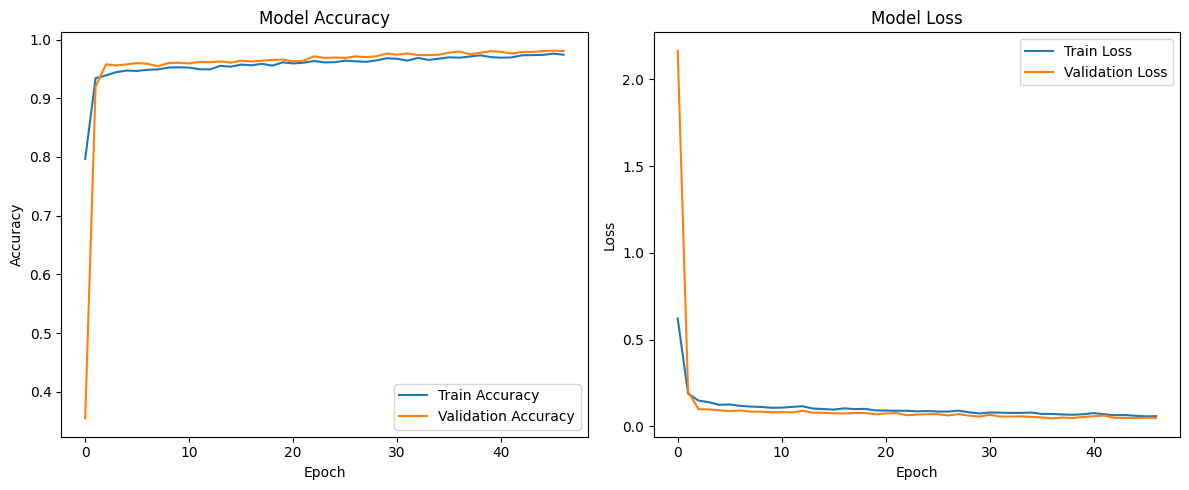

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step

Evaluation Metrics:
Accuracy: 0.9535
Precision: 0.9554
Recall: 0.9535
F1 Score: 0.9532
Average Specificity: 0.9906

Class-wise Specificities:
Class 0 (WALKING): 0.9992
Class 1 (WALKING_UPSTAIRS): 0.9988
Class 2 (WALKING_DOWNSTAIRS): 0.9917
Class 3 (SITTING): 0.9898
Class 4 (STANDING): 0.9652
Class 5 (LAYING): 0.9992


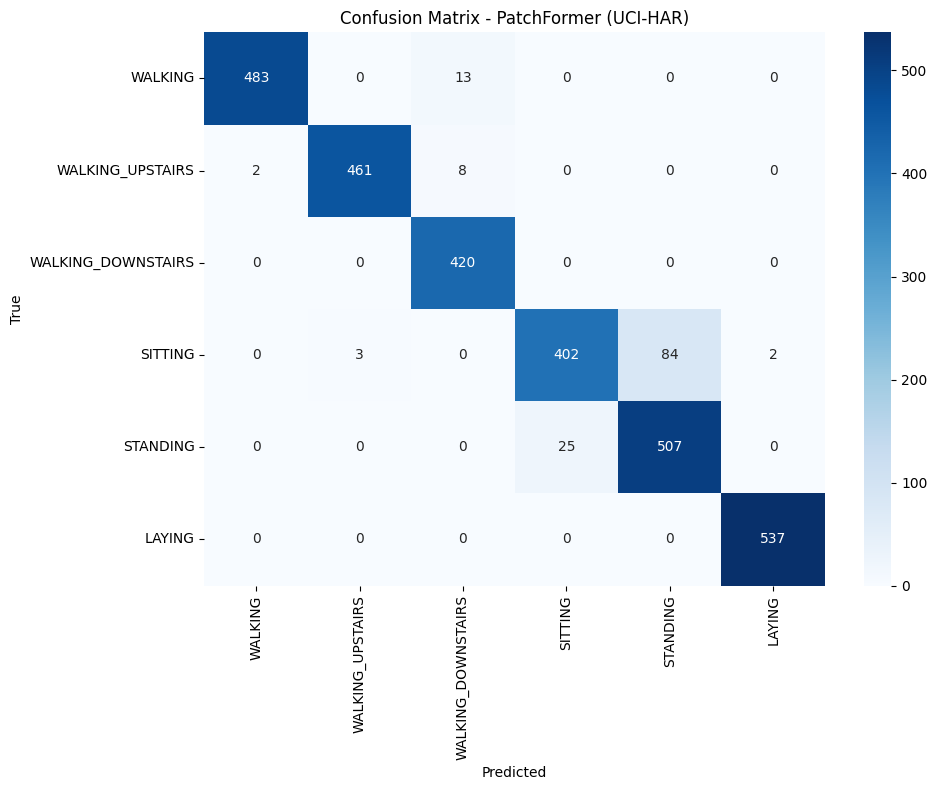

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks


# Assuming your activity labels are in a CSV file, load them
# Replace 'activity_labels.csv' with the actual file path
try:
    activity_labels = pd.read_csv('activity_labels.csv')
except FileNotFoundError:
    # If the file doesn't exist, create a DataFrame manually
    activity_labels = pd.DataFrame({
        'class_name': ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
        'label': [0, 1, 2, 3, 4, 5]  # Assuming labels are 0-indexed
    })

y_pred_probs = model3.predict(X_test_seq)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test_seq_onehot, axis=1)  # Get true labels from one-hot encoded data


precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
# Calculate specificity for each class
def specificity_score(y_true, y_pred, num_classes=6):
    specificities = []

    for i in range(num_classes):
        true_negative = np.sum((y_true != i) & (y_pred != i))
        false_positive = np.sum((y_true != i) & (y_pred == i))

        if true_negative + false_positive == 0:
            specificities.append(1.0)
        else:
            specificities.append(true_negative / (true_negative + false_positive))

    return specificities

specificities = specificity_score(y_true, y_pred)
avg_specificity = np.mean(specificities)

test_loss, test_acc = model3.evaluate(X_test_seq, y_test_seq_onehot, verbose=0)

print("\nEvaluation Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")

print("\nClass-wise Specificities:")
for i, spec in enumerate(specificities):
    print(f"Class {i} ({activity_labels.iloc[i, 0]}): {spec:.4f}") # Assuming 'class_name' is in the first column (index 0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=activity_labels['class_name'].values,
           yticklabels=activity_labels['class_name'].values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - PatchFormer (UCI-HAR)')
plt.tight_layout()
plt.show()

In [16]:
'''

Input (batch_size, time_steps, channels)
    ↓
[Initial Projection]
    Conv1D(kernel=1, filters=64) → BatchNorm → ReLU
    ↓
    Conv1D(kernel=1, filters=128) → BatchNorm → ReLU
    ↓
[Multi-Scale CNN Path]
    ┌─ Conv1D(kernel=3,  filters=128/3≈42) → BatchNorm
    ├─ Conv1D(kernel=7,  filters=128/3≈42) → BatchNorm
    └─ Conv1D(kernel=11, filters=128/3≈42) → BatchNorm
        ↓
    Concatenate(branches) → Conv1D(kernel=1, filters=128) → BatchNorm → ReLU
    ↓
[ABFA Block]
    • 입력 차원: (time_steps, 128)
    • action_prototypes: (num_classes, 128)
    • 내부:
        – Dense→프로젝트 → proto 유사도 계산 → softmax attention
        – attention ⊗ prototypes → augment_proj → residual + BN → Dropout → LayerNorm
    ↓
[MST_Block]
    • DepthwiseConv1D(kernel=3) → Conv1D(filters=32)
    • DepthwiseConv1D(kernel=5) → Conv1D(filters=32)
    • DepthwiseConv1D(kernel=7) → Conv1D(filters=64)
        ↓
    Concatenate → Conv1D(kernel=1, filters=128)
    ↓
[Transformer Encoder Block]
    MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
      → Add(x) → LayerNormalization
    ↓
    Feed-Forward: Dense(128, ReLU) → Dense(128)
      → Add(x) → LayerNormalization
    ↓
GlobalAveragePooling1D
    ↓
Dense(128, ReLU) → Dropout(0.2) → Dense(64, ReLU)
    ↓
Dense(num_classes, Softmax)
초기 투영(Initial Projection): 1×1 컨볼루션으로 채널 차원 확장

다중 스케일 CNN(Multi-Scale CNN Path): 서로 다른 커널 크기로 병렬 특징 추출 후 통합

ABFA Block: 학습된 행동 프로토타입과의 attention 기반 특징 증강

MST_Block: 깊이별(depthwise) 컨볼루션으로 다중 스케일 시간 특징 캡처

Transformer Encoder: 자기-어텐션과 FFN으로 시퀀스 전역 관계 학습

분류기(Classifier): 전역 풀링 후 완전 연결 계층으로 최종 클래스 예측

'''

'\n\nInput (batch_size, time_steps, channels)\n    ↓\n[Initial Projection]\n    Conv1D(kernel=1, filters=64) → BatchNorm → ReLU\n    ↓\n    Conv1D(kernel=1, filters=128) → BatchNorm → ReLU\n    ↓\n[Multi-Scale CNN Path]\n    ┌─ Conv1D(kernel=3,  filters=128/3≈42) → BatchNorm\n    ├─ Conv1D(kernel=7,  filters=128/3≈42) → BatchNorm\n    └─ Conv1D(kernel=11, filters=128/3≈42) → BatchNorm\n        ↓\n    Concatenate(branches) → Conv1D(kernel=1, filters=128) → BatchNorm → ReLU\n    ↓\n[ABFA Block]\n    • 입력 차원: (time_steps, 128)\n    • action_prototypes: (num_classes, 128)\n    • 내부: \n        – Dense→프로젝트 → proto 유사도 계산 → softmax attention  \n        – attention ⊗ prototypes → augment_proj → residual + BN → Dropout → LayerNorm\n    ↓\n[MST_Block]\n    • DepthwiseConv1D(kernel=3) → Conv1D(filters=32)\n    • DepthwiseConv1D(kernel=5) → Conv1D(filters=32)\n    • DepthwiseConv1D(kernel=7) → Conv1D(filters=64)\n        ↓\n    Concatenate → Conv1D(kernel=1, filters=128)\n    ↓\n[Transformer Enco